#Day 3 (New Task): CNN vs. Optimized CNN on EmotionNet-6
On Day 2, we beat the "Fruits" dataset with a basic CNN. On Day 3, we learned to optimize it.

Now, let's apply that knowledge to a brand new, more difficult dataset: "EmotionNet-6", which contains 6 classes of human facial expressions.

Today's Plan:

Download & Unzip: Use kagglehub to get the new dataset.

Load Data: Load the new grayscale images.

Phase 1: Basic CNN (Day 2 Model): We'll train our simple Day 2 CNN and see how it performs on this new challenge.

Phase 2: Optimized CNN (Day 3 Model): We'll train our "Pro" CNN with BatchNormalization and GlobalAveragePooling2D to see how much it improves stability and accuracy.

Compare: We'll compare the two models side-by-side.

https://www.kaggle.com/datasets/isrcoimbra/emotionnet-6-realistic-facial-emotion-dataset

##Cell 1: Setup - Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import math
import zipfile
import kagglehub
from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(f"TensorFlow Version: {tf.__version__}")
print("All libraries imported.")

TensorFlow Version: 2.19.0
All libraries imported.


##Cell 2: Download & Unzip Data
First, let's install the kagglehub library. Then, we'll download and unzip our new dataset.

In [2]:
!pip install kagglehub

# Download latest version
print("Downloading EmotionNet-6 dataset...")
# The kagglehub tool downloads AND automatically extracts the files
path = kagglehub.dataset_download("isrcoimbra/emotionnet-6-realistic-facial-emotion-dataset")

print("Dataset downloaded and extracted to:", path)

100%|██████████| 4.19G/4.19G [01:51<00:00, 40.2MB/s]

Extracting files...


Dataset downloaded and extracted to: /root/.cache/kagglehub/datasets/isrcoimbra/emotionnet-6-realistic-facial-emotion-dataset/versions/3


##Cell 3: Define Dataset Parameters
Critical Changes:

This dataset has different classes and image properties.

We'll use IMG_SIZE = 96 for better facial detail.

The images are grayscale, so CHANNELS = 1.

In [3]:
# We will resize all images to 96x96 for more detail
IMG_SIZE = 96
print(f"Image size set to: {IMG_SIZE}x{IMG_SIZE} pixels")

# We will train in batches of 32 images at a time
BATCH_SIZE = 32
print(f"Batch size set to: {BATCH_SIZE}")

# CRITICAL: These images are grayscale
CHANNELS = 1
print(f"Number of color channels: {CHANNELS}")

# --- FIX ---
# Our dataset has 5 classes (as found in Cell 4)
NUM_CLASSES = 5
# -------------

print(f"Number of classes: {NUM_CLASSES}")

Image size set to: 96x96 pixels
Batch size set to: 32
Number of color channels: 1
Number of classes: 5


##Cell 4: Define File Paths
The unzipped folder is named emotionnet-6-realistic-facial-emotion-dataset.

In [4]:
import math
import os

# The 'path' variable from kagglehub (Cell 2) is our download directory
download_dir = path

# The actual data is in a subfolder *inside* the download directory
# We must go *two levels deep* to find the class folders
base_dir = os.path.join(download_dir, "EmotionNet-6", "EmotionNet-6")
print(f"Base directory set to: {base_dir}")

# --- NEW: Count the images ---
# We need to do this first to calculate steps_per_epoch
image_count = 0
# List subfolders (angry, disgust, etc.)
try:
    class_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
    print(f"Found class folders: {class_folders}")

    for folder in class_folders:
        try:
            # Count files in each class folder
            image_count += len(os.listdir(os.path.join(base_dir, folder)))
        except NotADirectoryError:
            # Ignore any non-directory files
            continue
except FileNotFoundError:
    print(f"--- ERROR ---")
    print(f"The folder {base_dir} was not found. This is a common Kaggle pathing issue.")
    print("Please double-check the folder names in your environment.")
    raise

print(f"\nFound a total of {image_count} images in {len(class_folders)} classes.")

# Calculate 80% for training, 20% for validation
TRAIN_IMAGES = math.ceil(image_count * 0.8)
TEST_IMAGES = image_count - TRAIN_IMAGES
NUM_CLASSES = len(class_folders) # This is more robust

# Calculate steps
steps_per_epoch = math.ceil(TRAIN_IMAGES / BATCH_SIZE)
validation_steps = math.ceil(TEST_IMAGES / BATCH_SIZE)

print(f"Using {TRAIN_IMAGES} for training ({steps_per_epoch} steps per epoch)")
print(f"Using {TEST_IMAGES} for validation ({validation_steps} steps per epoch)")

# --- Now we load the data ---
print("\nLoading Training Data (80% split)...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    color_mode='grayscale',
    validation_split=0.2,  # <-- Create a 20% validation split
    subset='training',   # <-- This is the 80% training part
    seed=123
)

print("\nLoading Validation (Test) Data (20% split)...")
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    color_mode='grayscale',
    validation_split=0.2,
    subset='validation', # <-- This is the 20% validation part
    seed=123
)

# Get Class Names
class_names = train_dataset.class_names
print(f"\nLoaded class names: {class_names}")

# Configure for Performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_dataset.cache().repeat().prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().repeat().prefetch(buffer_size=AUTOTUNE)
print("Applied .cache(), .repeat(), and .prefetch() to both datasets.")

Base directory set to: /root/.cache/kagglehub/datasets/isrcoimbra/emotionnet-6-realistic-facial-emotion-dataset/versions/3/EmotionNet-6/EmotionNet-6
Found class folders: ['Fear', 'Sad', 'Happy', 'Angry', 'Normal']

Found a total of 500 images in 5 classes.
Using 400 for training (13 steps per epoch)
Using 100 for validation (4 steps per epoch)

Loading Training Data (80% split)...
Found 500 files belonging to 5 classes.
Using 400 files for training.

Loading Validation (Test) Data (20% split)...
Found 500 files belonging to 5 classes.
Using 100 files for validation.

Loaded class names: ['Angry', 'Fear', 'Happy', 'Normal', 'Sad']
Applied .cache(), .repeat(), and .prefetch() to both datasets.


##Cell 5: Load and Prepare Datasets
Here, we will use color_mode='grayscale' to load the images correctly.

##Cell 6: FIXME - Set File Counts & Steps
The image_dataset_from_directory command above just told you how many files it found (e.g., "Found 12000 files belonging to 6 classes.").

Please enter those numbers below to calculate the steps per epoch.

In [5]:
import math

# --- FIXME ---
# Enter the file counts you saw in the output from Cell 5
TRAIN_IMAGES = 400  # Replace with your 'Found X files' for training
TEST_IMAGES = 100   # Replace with your 'Found Y files' for test
# -------------

# Calculate steps_per_epoch for training
steps_per_epoch = math.ceil(TRAIN_IMAGES / BATCH_SIZE)

# Calculate validation_steps for testing
validation_steps = math.ceil(TEST_IMAGES / BATCH_SIZE)

print(f"Total training steps per epoch: {steps_per_epoch}")
print(f"Total validation steps per epoch: {validation_steps}")

Total training steps per epoch: 13
Total validation steps per epoch: 4


##Cell 7: Visualize the Data (Quick Check)
Let's look at the data. We must use cmap='gray' to plot it correctly.

Plotting 9 sample images from the training data...


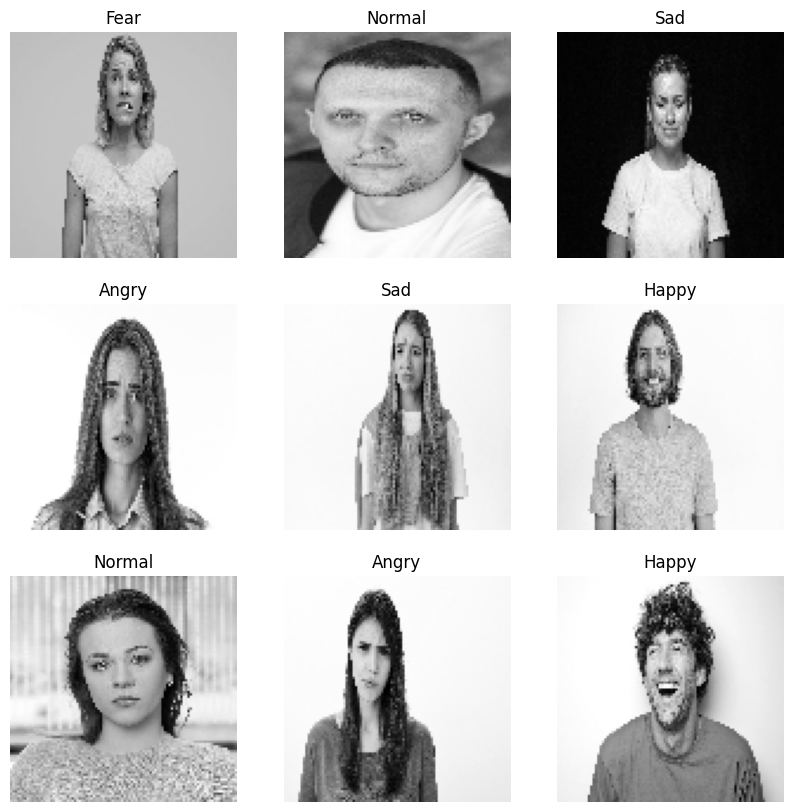

In [6]:
plt.figure(figsize=(10, 10))
print("Plotting 9 sample images from the training data...")
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        # Use np.squeeze to remove the 1-channel dimension for plotting
        plt.imshow(np.squeeze(images[i].numpy().astype("uint8")), cmap='gray')
        class_index = np.argmax(labels[i])
        plt.title(class_names[class_index])
        plt.axis("off")
plt.show()

#Phase 1: Basic CNN (Day 2 Model)
Let's see how our simple CNN from Day 2 handles this new problem.

In [7]:
# --- Build the Basic CNN (Functional API) ---
inputs_basic = keras.Input(shape=(IMG_SIZE, IMG_SIZE, CHANNELS), name='input_image_basic')
x = layers.Rescaling(1./255, name='rescaling_basic')(inputs_basic)
x = layers.Conv2D(16, (3, 3), activation='relu', name='conv_basic_1')(x)
x = layers.MaxPooling2D((2, 2), name='maxpool_basic_1')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', name='conv_basic_2')(x)
x = layers.MaxPooling2D((2, 2), name='maxpool_basic_2')(x)
x = layers.Flatten(name='flatten_basic')(x)
x = layers.Dense(64, activation='relu', name='dense_basic')(x)
x = layers.Dropout(0.5, name='dropout_basic')(x)
outputs_basic = layers.Dense(NUM_CLASSES, activation='softmax', name='output_basic')(x)

model_cnn = keras.Model(inputs=inputs_basic, outputs=outputs_basic, name="Basic_CNN")

print("Basic CNN model built successfully.")
model_cnn.summary()

Basic CNN model built successfully.


Model: "Basic_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image_basic (InputLayer)  │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_basic (Rescaling)     │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_basic_1 (Conv2D)           │ (None, 94, 94, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_basic_1 (MaxPooling2D)  │ (None, 47, 47, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_basic_2 (Conv2D)           │ (None, 45, 45, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_basic_2 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_basic (Flatten)         │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_basic (Dense)             │ (None, 64)             │       991,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_basic (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_basic (Dense)            │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 996,421 (3.80 MB)

 Trainable params: 996,421 (3.80 MB)

 Non-trainable params: 0 (0.00 B)

##Cell 9: Compile and Train Basic CNN

In [8]:
model_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Basic CNN compiled.")

Basic CNN compiled.


In [9]:
print("Starting Basic CNN model training for 20 epochs...")
history_cnn = model_cnn.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

print("\nBasic CNN training complete.")

Starting Basic CNN model training for 20 epochs...
Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 86s 6s/step - accuracy: 0.2038 - loss: 1.6688 - val_accuracy: 0.2300 - val_loss: 1.5979
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 290ms/step - accuracy: 0.3205 - loss: 1.5753 - val_accuracy: 0.3300 - val_loss: 1.5194
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3082 - loss: 1.5041 - val_accuracy: 0.4400 - val_loss: 1.3852
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3661 - loss: 1.4085 - val_accuracy: 0.3700 - val_loss: 1.3617
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3831 - loss: 1.4082 - val_accuracy: 0.4500 - val_loss: 1.3300
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4525 - loss: 1.2711 - val_accuracy: 0.3900 - val_loss: 1.3218
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4895 - loss: 1.2182 - val_accuracy: 0.4500 - val_loss: 1.2777
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4

##Cell 10: Visualize Basic CNN Training

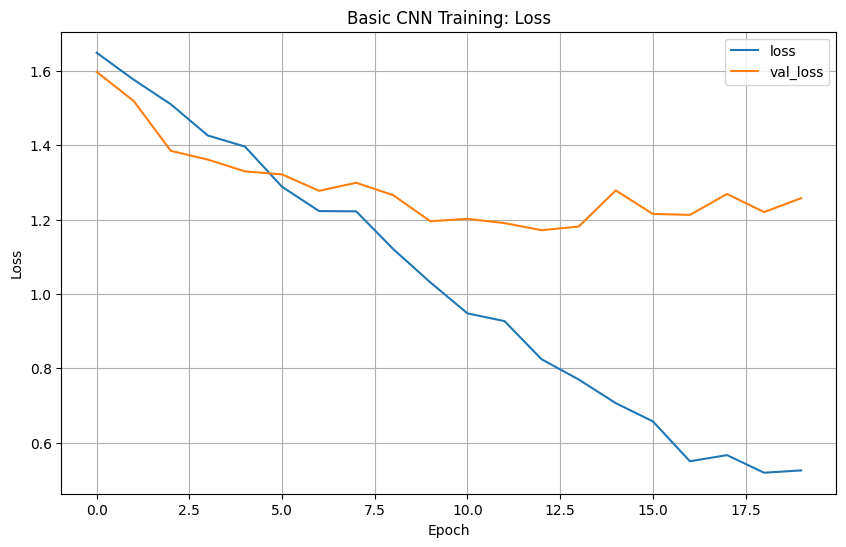

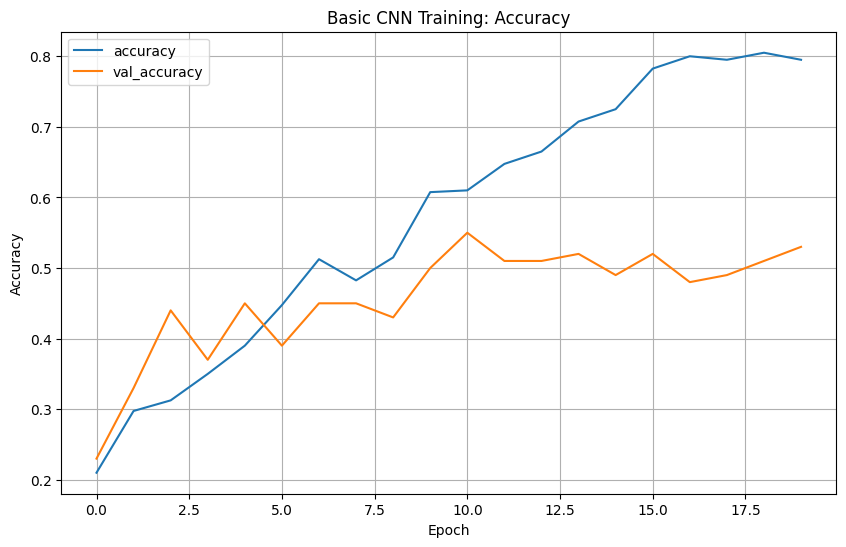

The best validation accuracy our Basic CNN achieved was: 55.00%


In [10]:
# Convert the history to a DataFrame
history_cnn_df = pd.DataFrame(history_cnn.history)

# Plot Loss
history_cnn_df[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.title("Basic CNN Training: Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Plot Accuracy
history_cnn_df[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.title("Basic CNN Training: Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# Get the final, best validation accuracy
final_cnn_acc = max(history_cnn.history['val_accuracy'])
print(f"The best validation accuracy our Basic CNN achieved was: {final_cnn_acc * 100:.2f}%")

#Phase 2: Optimized CNN (Day 3 "Pro" Model)
The Basic CNN probably did okay, but it likely started to overfit after 10-15 epochs.

###Now, let's build our Optimized "Pro" CNN (the one from Day 3 with BatchNormalization and GlobalAveragePooling2D) and see if it performs better and is more stable.

In [39]:
# --- Build the "Pro" CNN (Functional API) ---
inputs_pro = keras.Input(shape=(IMG_SIZE, IMG_SIZE, CHANNELS), name='input_image_pro')

x = layers.Rescaling(1./255, name='rescaling_pro')(inputs_pro)

# --- 1. First Conv Block ---
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1a')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1b')(x)
x = layers.BatchNormalization(name='batchnorm_1')(x)
x = layers.MaxPooling2D((2, 2), name='maxpool_1')(x)

# --- 2. Second Conv Block ---
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2a')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2b')(x)
x = layers.BatchNormalization(name='batchnorm_2')(x)
x = layers.MaxPooling2D((2, 2), name='maxpool_2')(x)

# --- 3. Third Conv Block ---
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3a')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3b')(x)
x = layers.BatchNormalization(name='batchnorm_3')(x)
x = layers.MaxPooling2D((2, 2), name='maxpool_3')(x)

# --- 4. Global Average Pooling ---
x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)

# --- 5. Final Head ---
x = layers.Dense(128, activation='relu', name='dense_1')(x)
x = layers.Dropout(0.4, name='dropout_final')(x)
outputs_pro = layers.Dense(NUM_CLASSES, activation='softmax', name='output_layer_pro')(x)

model_pro_cnn = keras.Model(inputs=inputs_pro, outputs=outputs_pro, name="Pro_CNN")

print("Pro CNN model built successfully.")
model_pro_cnn.summary()

Pro CNN model built successfully.


Model: "Pro_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image_pro (InputLayer)    │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_pro (Rescaling)       │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1a (Conv2D)                │ (None, 96, 96, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1b (Conv2D)                │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2a (Conv2D)                │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2b (Conv2D)                │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3a (Conv2D)                │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3b (Conv2D)                │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling2D)        │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_final (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer_pro (Dense)        │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,485 (1.16 MB)

 Trainable params: 304,037 (1.16 MB)

 Non-trainable params: 448 (1.75 KB)

In [11]:

# Cell defining the "Pro" Model (NOW WITH AUGMENTATION)

# 1. Define the augmentation layers
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.1),
], name="data_augmentation")

# 2. Define the model Input
inputs_pro = keras.Input(shape=(IMG_SIZE, IMG_SIZE, CHANNELS), name='input_image_pro')

# 3. Apply augmentation *after* the Input
x = data_augmentation(inputs_pro)

# 4. Apply rescaling *after* augmentation
x = layers.Rescaling(1./255, name='rescaling_pro')(x)

# --- 1. First Conv Block ---
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1a')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1b')(x)
x = layers.BatchNormalization(name='batchnorm_1')(x)
x = layers.MaxPooling2D((2, 2), name='maxpool_1')(x)

# --- 2. Second Conv Block ---
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2a')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2b')(x)
x = layers.BatchNormalization(name='batchnorm_2')(x)
x = layers.MaxPooling2D((2, 2), name='maxpool_2')(x)

# --- 3. Third Conv Block ---
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3a')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3b')(x)
x = layers.BatchNormalization(name='batchnorm_3')(x)
x = layers.MaxPooling2D((2, 2), name='maxpool_3')(x)

# --- 4. Global Average Pooling ---
x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)

# --- 5. Final Head ---
x = layers.Dense(128, activation='relu', name='dense_1')(x)
x = layers.Dropout(0.4, name='dropout_final')(x)
outputs_pro = layers.Dense(NUM_CLASSES, activation='softmax', name='output_layer_pro')(x)

model_pro_cnn = keras.Model(inputs=inputs_pro, outputs=outputs_pro, name="Pro_CNN")

print("Pro CNN model built successfully.")
model_pro_cnn.summary()

Pro CNN model built successfully.


Model: "Pro_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image_pro (InputLayer)    │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_pro (Rescaling)       │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1a (Conv2D)                │ (None, 96, 96, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1b (Conv2D)                │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2a (Conv2D)                │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2b (Conv2D)                │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3a (Conv2D)                │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3b (Conv2D)                │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling2D)        │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_final (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer_pro (Dense)        │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,485 (1.16 MB)

 Trainable params: 304,037 (1.16 MB)

 Non-trainable params: 448 (1.75 KB)

##Cell 12: Compile and Train "Pro" CNN

In [12]:
model_pro_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Pro CNN model compiled.")

Pro CNN model compiled.


In [13]:
print("Starting Pro CNN model training for 30 epochs...")
history_pro_cnn = model_pro_cnn.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

print("\nPro CNN training complete.")

Starting Pro CNN model training for 30 epochs...
Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.1940 - loss: 1.8438 - val_accuracy: 0.2500 - val_loss: 1.6056
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.2327 - loss: 1.6975 - val_accuracy: 0.2700 - val_loss: 1.5945
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3259 - loss: 1.5357 - val_accuracy: 0.2700 - val_loss: 1.5923
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3434 - loss: 1.5084 - val_accuracy: 0.2700 - val_loss: 1.6064
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3508 - loss: 1.4657 - val_accuracy: 0.2700 - val_loss: 1.6316
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3889 - loss: 1.3765 - val_accuracy: 0.2700 - val_loss: 1.6801
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3940 - loss: 1.3876 - val_accuracy: 0.2700 - val_loss: 1.7023
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accurac

##Cell 13: Visualize "Pro" CNN Training

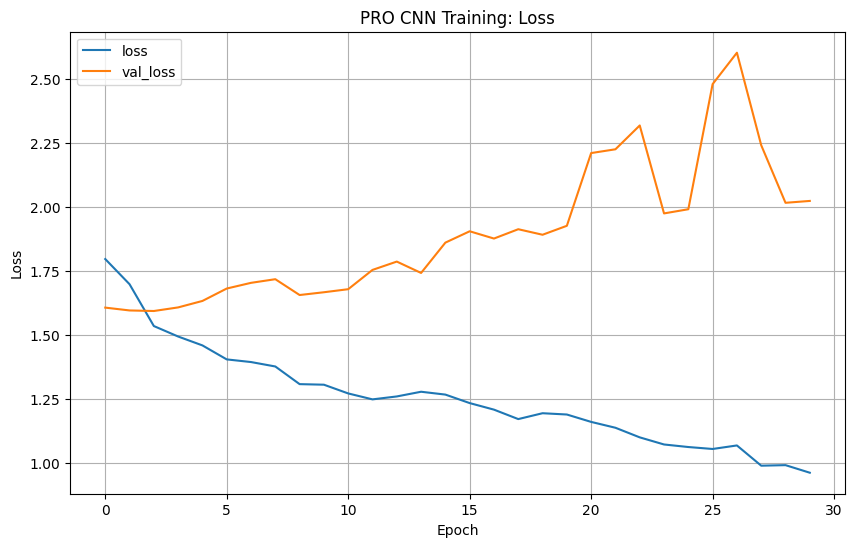

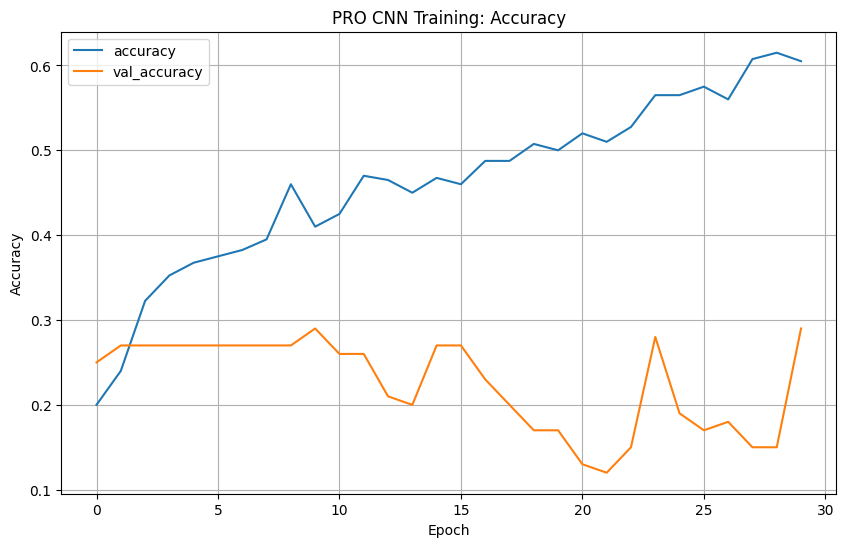

The best validation accuracy our PRO CNN achieved was: 29.00%


In [14]:
# Convert the new history to a DataFrame
history_pro_df = pd.DataFrame(history_pro_cnn.history)

# Plot Loss
history_pro_df[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.title("PRO CNN Training: Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Plot Accuracy
history_pro_df[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.title("PRO CNN Training: Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# Get the final, best validation accuracy
final_pro_acc = max(history_pro_cnn.history['val_accuracy'])
print(f"The best validation accuracy our PRO CNN achieved was: {final_pro_acc * 100:.2f}%")

##Cell 14: Final Model Comparison
Now let's compare the two models on this new dataset.

In [15]:
print("Evaluating all models on the EmotionNet-6 validation data...")

# Evaluate Basic CNN (Day 2)
cnn_score = model_cnn.evaluate(val_ds, steps=validation_steps, verbose=0)
cnn_params = model_cnn.count_params()

# Evaluate Pro CNN (Day 3)
pro_cnn_score = model_pro_cnn.evaluate(val_ds, steps=validation_steps, verbose=0)
pro_cnn_params = model_pro_cnn.count_params()


# --- Print the comparison table ---
print("\n\n--- FINAL MODEL COMPARISON (EmotionNet-6) ---")
print("-------------------------------------------------------------------------")
print(f"| Model               | Parameters    | Final Validation Accuracy |")
print("-------------------------------------------------------------------------")
print(f"| 1. Basic CNN (Day 2)| {cnn_params:<13} | {cnn_score[1]*100:<25.2f}% |")
print(f"| 2. Pro CNN (Day 3)  | {pro_cnn_params:<13} | {pro_cnn_score[1]*100:<25.2f}% |")
print("-------------------------------------------------------------------------")

Evaluating all models on the EmotionNet-6 validation data...


--- FINAL MODEL COMPARISON (EmotionNet-6) ---
-------------------------------------------------------------------------
| Model               | Parameters    | Final Validation Accuracy |
-------------------------------------------------------------------------
| 1. Basic CNN (Day 2)| 996421        | 53.00                    % |
| 2. Pro CNN (Day 3)  | 304485        | 29.00                    % |
-------------------------------------------------------------------------


##Cell 15: Final Predictions (Pro Model)
Let's finish by running our best model, the model_pro_cnn, on a batch of test images.

Making predictions with model_pro_cnn on a batch of validation images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Plotting Pro CNN prediction grid...


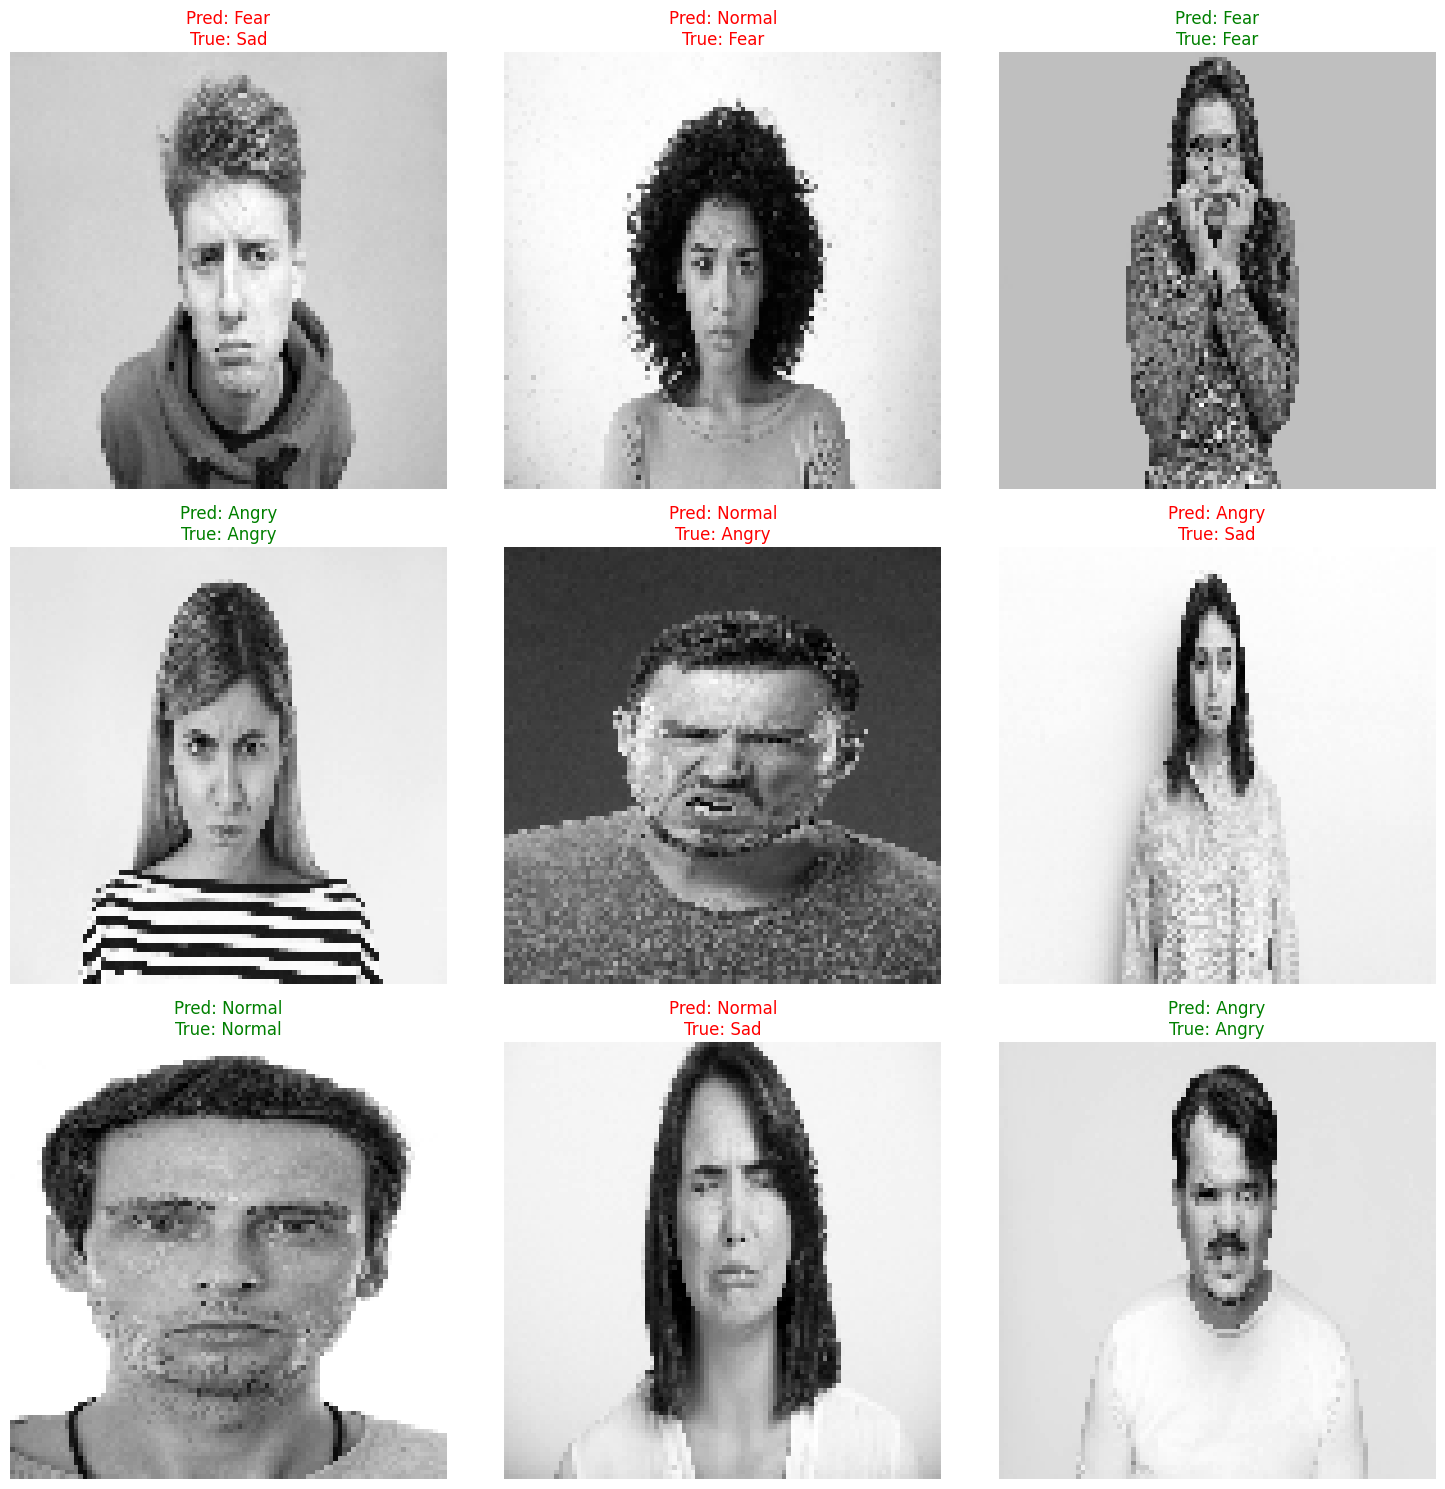

In [16]:
# Get one batch of images and labels from the validation set
images_batch, labels_batch = next(iter(val_ds))

# Make predictions on this batch using the PRO CNN
print("Making predictions with model_pro_cnn on a batch of validation images...")
predictions_batch = model_pro_cnn.predict(images_batch)

# Get the predicted class indices
predicted_indices = np.argmax(predictions_batch, axis=1)
# Get the true class indices
true_indices = np.argmax(labels_batch.numpy(), axis=1)

# --- Plot the results ---
plt.figure(figsize=(15, 15))
print("Plotting Pro CNN prediction grid...")

for i in range(9):
    plt.subplot(3, 3, i + 1)
    # Use np.squeeze to plot the grayscale image
    plt.imshow(np.squeeze(images_batch[i].numpy().astype("uint8")), cmap='gray')

    pred_label = class_names[predicted_indices[i]]
    true_label = class_names[true_indices[i]]

    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()